# 2D Forward Slice Model

Aim to build imaging model for OPT.

Kind of similar to what we were doing in `inverse.ipynb`.

Have 2D slice

**Algorithm**

For each angle
1. Convolve with 2D MTF
2. Take projection
3. Rotate slice
4. Repeat

**Notes on measures and units** 
* Image width in mm is $w$.
* Pixel size is $e$.
* Frequency spacing is $\Delta k = 1/w$ line pairs per mm
* Nyquist frequency is $k_{\max} = 1/(2e)$, is your maximum spatial frequency.
* Have $N_\text{pixels} = w/e$ and $k_{\max}/ {\Delta k} = N_\text{pixels} / 2$. 

**To do**
* Implement our actual filtering

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftshift, fftfreq

# Image Processing
from skimage.transform import radon, rescale, iradon
from PIL import Image

# Data
from skimage.data import shepp_logan_phantom

In [11]:
# Generate Gaussian profiles
def gaussian(x, sigma):
    return np.exp(-x**2/(2*sigma**2))

### Define 2D frequency filter

van der Horst and Kalkman choose a Gaussian PSF. 

(1040, 1040)


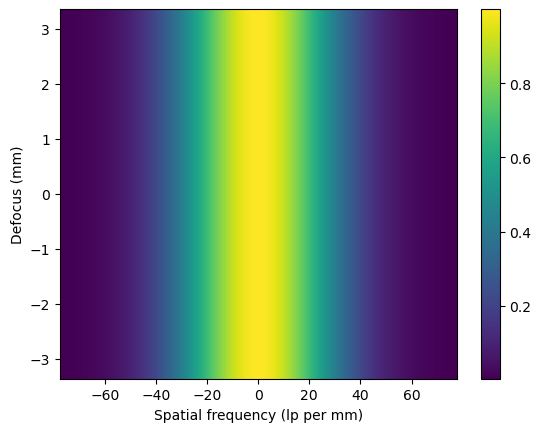

In [53]:
N_pixels = 1040
e = 6.45e-3 # Pixel size (mm)
nyquist_freq = 1/(2*e) # Nyquist frequency (line pairs per mm)

filter = np.zeros((N_pixels, N_pixels)) # dimensions: defocus, spatial frequency
frequencies = np.linspace(-nyquist_freq, nyquist_freq, N_pixels)
defocuses = np.linspace(-N_pixels * e /2, +N_pixels * e /2, N_pixels) # defocuses (mm)

# populate 2D filter matrix
for i in range(len(filter)):
    filter[i] = gaussian(frequencies, 23)

K, S = np.meshgrid(frequencies, defocuses)
plt.pcolormesh(K, S, filter)
plt.xlabel('Spatial frequency (lp per mm)')
plt.ylabel('Defocus (mm)')
print(filter.shape)
# plt.imshow() 
plt.colorbar()
fftshifted_filter = fftshift(filter, 1)

van der Horst MTF
* A more realistic filter than the previous one

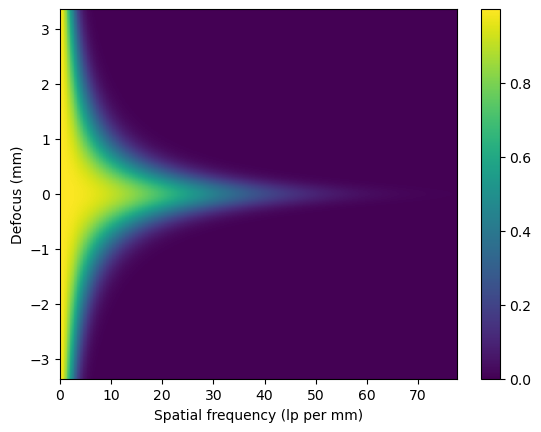

In [174]:
def beam_waist(s, w0, lamb):
    # Returns beam waist at position s
    # s: defocus (m)
    # w0: min beam waist (m)
    # lamb: wavelength (m)
    return np.sqrt(w0*w0 + (lamb*s/np.pi/w0)**2)

# def gaussian_psf(t,s, w0, lamb):
#     # Returns gaussian psf as func of t at defocus s
#     w = beam_waist(s, w0, lamb)
#     return 1/ (w * np.sqrt(2*np.pi)) * np.exp(-0.5 * (t/w)**2)

w0 = 6.92e-6 # minimum beam_waist trial and error (m)
lamb = 525e-9 # Wavelength of light used (m)
t = np.linspace(-N_pixels*e/2e3, N_pixels*e/2e3, N_pixels)
# t = np.linspace(-100e-6, 100e-6)

gaussian_filter = np.zeros((N_pixels, N_pixels))
beam_waist_depths = beam_waist(defocuses/1e3, w0, lamb)

# FT of a Gaussian with sigma= beam_waist gives you a Gaussian with sigma_prime
sigma_prime = 1/(2*np.pi * beam_waist_depths)/1000 # units (lp /mm)

for i in range(len(filter)):
    gaussian_filter[i] = gaussian(frequencies, sigma_prime[i])

plt.xlabel('Spatial frequency (lp per mm)')
plt.ylabel('Defocus (mm)')
plt.pcolormesh(K, S, gaussian_filter)
plt.colorbar()
plt.xlim(0, nyquist_freq)
plt.show()
fftshifted_gaus_MTF = fftshift(gaussian_filter, 1)

Text(0.5, 1.0, 'MTF at f/17 (vd Horst Gaussian model)')

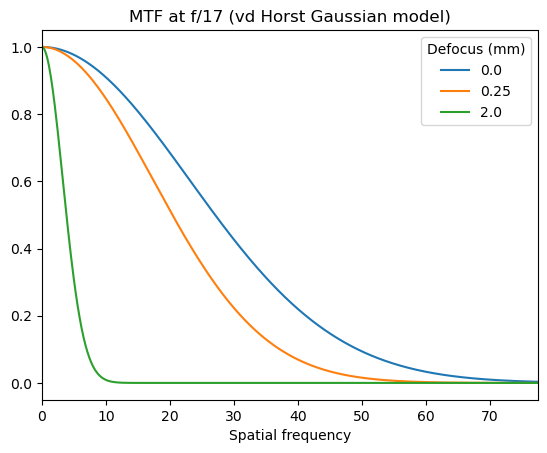

In [160]:
plt.plot(frequencies, gaussian(frequencies, sigma_prime[520]/1000), label='0.0')
plt.plot(frequencies, gaussian(frequencies, 1/(2*np.pi*beam_waist(0.25e-3, w0, lamb))/1000), label='0.25')
plt.plot(frequencies, gaussian(frequencies, 1/(2*np.pi*beam_waist(2e-3, w0, lamb))/1000), label='2.0')
plt.xlim(0,nyquist_freq)
plt.legend(title='Defocus (mm)')
plt.xlabel('Spatial frequency')
plt.title('MTF at f/17 (vd Horst Gaussian model)')

## Define Forward Model

In [217]:
def forward_model(slice, fftshifted_MTF, angles):
    """ generates OPT sinogram, based on filtering from fftshifted_MTF
        OPT is done through angles

    Args:
        slice (2D np.aray): computational object to put through forward model
        fftshifted_MTF (2D np.array): _description_
        angles (1D np.array): array of angles OPT was performed through

    Returns:
        sinogram: sinogram of the OPT model
    """
    image_width = slice.shape[0] # number of pixels
    sinogram = np.zeros((num_angles, image_width))
    im_PIL = Image.fromarray(slice)
    
    for i in range(num_angles):
        # rotates anticlockwise
        theta = angles[i]
        rotated = np.array(im_PIL.rotate(theta, expand=False)) 
        # convolves each line in slice with PSF of that depth --> do in Fourier domain
        fourier_image = fft(rotated) * fftshifted_MTF
        # plt.imshow(np.abs(fourier_image))
        filtered = ifft(fourier_image)

        # and then sums to get the projection
        # take line integral to get the projection
        projection = np.sum(filtered, axis=0)
        sinogram[i] = np.abs(projection)

    return sinogram

num_angles = 400
angles = np.linspace(0, 360, num_angles, endpoint=False)

## Test Forward Model

Bead phantom

(400.0, 900.0)

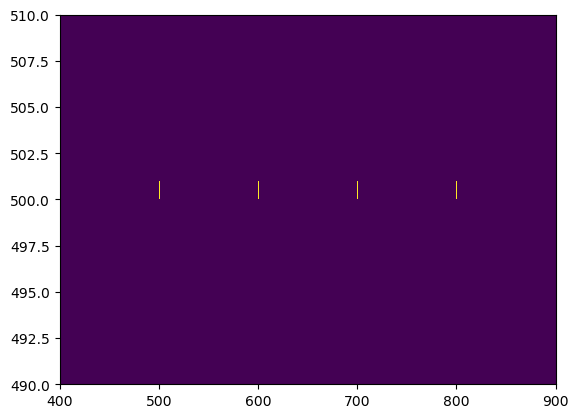

In [223]:
bead_phantom = np.zeros((N_pixels, N_pixels))

bead_phantom[500,500] = 1
bead_phantom[500,600] = 1
bead_phantom[500,700] = 1
bead_phantom[500,800] = 1
plt.pcolormesh(bead_phantom)
plt.ylim(490, 510)
plt.xlim(400, 900)


In [226]:
simulated_sinogram = forward_model(bead_phantom, fftshifted_gaus_MTF, angles).T
reconstruction = iradon(simulated_sinogram, -np.linspace(0, 360, 400, endpoint=False))

(400.0, 900.0)

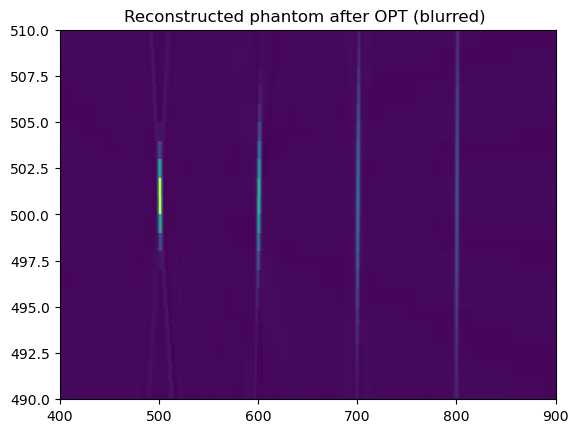

In [227]:
# plt.figure(figsize=(6, 4))
plt.pcolormesh(reconstruction)
plt.title('Reconstructed phantom after OPT (blurred) ')
# plt.colorbar()
plt.ylim(490, 510)
plt.xlim(400, 900)

In [228]:
simulated_sinogram = forward_model(bead_phantom, 1, angles).T
reconstruction = iradon(simulated_sinogram, -np.linspace(0, 360, 400, endpoint=False))

(400.0, 900.0)

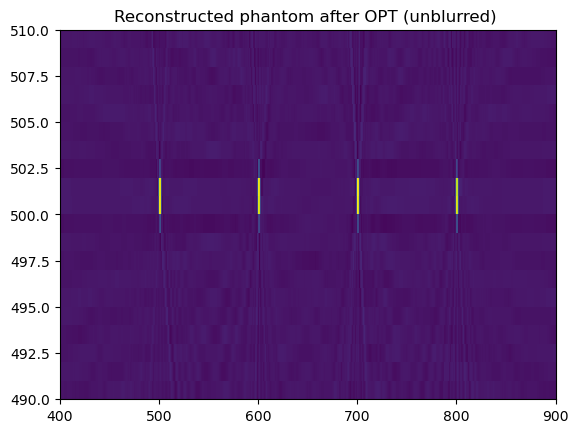

In [229]:
# plt.figure(figsize=(6, 3))
plt.pcolormesh(reconstruction)
plt.title('Reconstructed phantom after OPT (unblurred) ')
# plt.colorbar()
plt.ylim(490, 510)
plt.xlim(400, 900)

(490.0, 900.0)

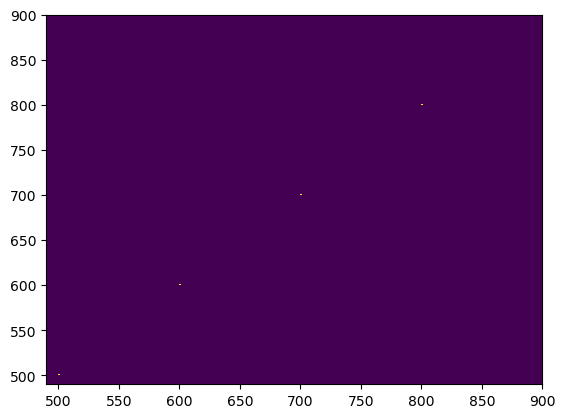

In [231]:
bead_phantom = np.zeros((N_pixels, N_pixels))

bead_phantom[500,500] = 1
bead_phantom[600,600] = 1
bead_phantom[700,700] = 1
bead_phantom[800,800] = 1
plt.pcolormesh(bead_phantom)
plt.ylim(490, 900)
plt.xlim(490, 900)

In [232]:
simulated_sinogram = forward_model(bead_phantom, fftshifted_gaus_MTF, angles).T
reconstruction = iradon(simulated_sinogram, -np.linspace(0, 360, 400, endpoint=False))

(490.0, 900.0)

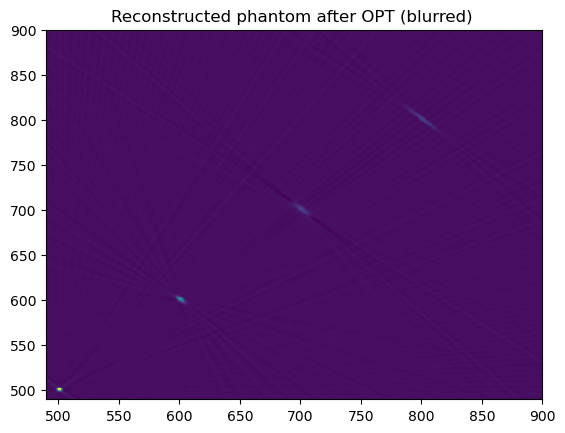

In [234]:
# plt.figure(figsize=(6, 4))
plt.pcolormesh(reconstruction)
plt.title('Reconstructed phantom after OPT (blurred) ')
# plt.colorbar()
plt.ylim(490, 900)
plt.xlim(490, 900)

### Shepp Logan Phantom

Text(0.5, 1.0, 'Phantom')

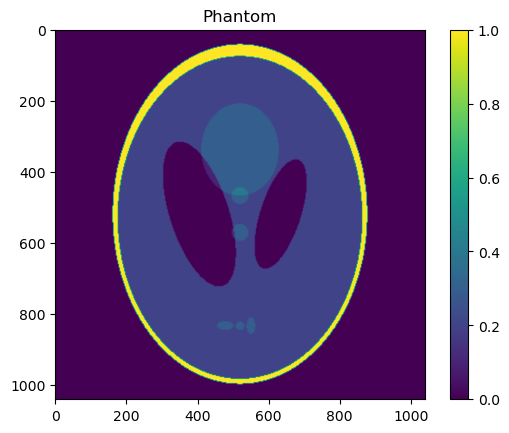

In [180]:
phantom = shepp_logan_phantom()
phantom = rescale(phantom, scale=2.6, mode='reflect')
plt.imshow(phantom)
plt.colorbar()
plt.title('Phantom')

Text(0.5, 1.0, 'Reconstructed phantom after OPT ')

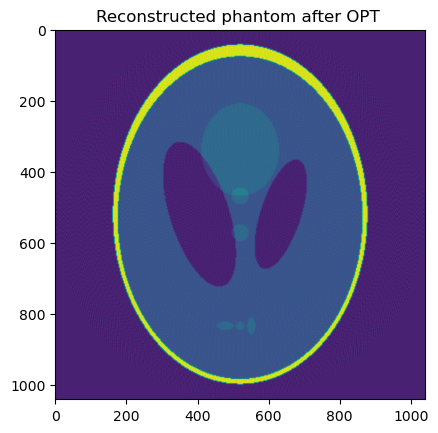

In [181]:
simulated_sinogram = forward_model(phantom, fftshifted_gaus_MTF, angles).T

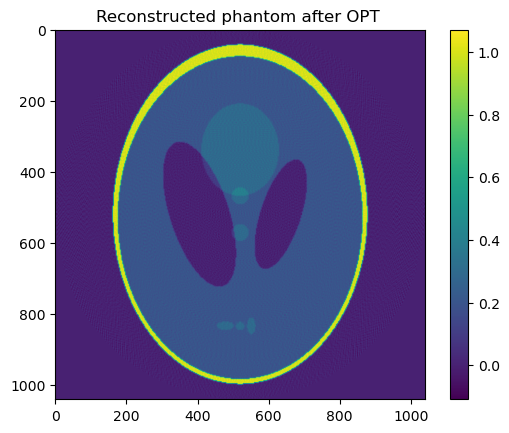

In [182]:
plt.imshow(iradon(simulated_sinogram, -np.linspace(0, 360, 400, endpoint=False)))
plt.title('Reconstructed phantom after OPT ')
plt.colorbar()

In [ ]:
phantom[200:230, 300:330] = 1
rotated = Image.fromarray(phantom).rotate(45.2, expand=False)
plt.imshow(np.array(rotated))

plt.plot(np.sum(rotated, axis=0))